# Deeptime objects

This notebook showcases two PySINDy objects designed according to the [Deeptime](https://deeptime-ml.github.io/index.html) API:
* `SINDyEstimator` - An estimator object which acts as a sort of factory for generating model objects
* `SINDyModel` - The SINDy model object which is learned from data and created by an estimator

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.5.1?filepath=examples/6_deeptime_compatibility.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz

import pysindy as ps

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-10
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

In [2]:
# Generate measurement data
dt = .002

# Train data
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords).y.T

In [3]:
# Fit an estimator
estimator = ps.deeptime.SINDyEstimator(t_default=dt)
estimator.fit(x_train);

The underlying model, represented by the `SINDyModel` class, comes equipped with all the methods of the `SINDy` class that are available after fitting (e.g. `predict`, `score`, `simulate`, `print`, `equations`). 

In [4]:
# Extract a model
model = estimator.fetch_model()

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


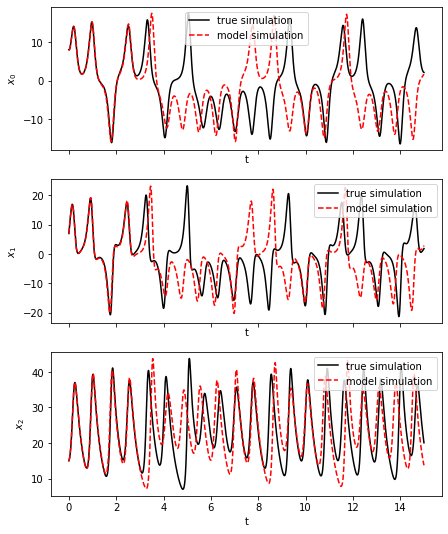

In [5]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

In [6]:
# Try out some other combinations of methods
estimator = ps.deeptime.SINDyEstimator(
    optimizer=ps.SR3(threshold=0.5, max_iter=50),
    feature_library=ps.PolynomialLibrary(degree=3)
)
estimator.fit(x_train, t=dt)

model = estimator.fetch_model()
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
